### 1. Problem Statement

create a model for predict whether person is surival or not

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import PowerTransformer,FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder,PowerTransformer,LabelEncoder,FunctionTransformer

from sklearn.compose import ColumnTransformer

from mixed_naive_bayes import MixedNB
from sklearn.metrics import classification_report,confusion_matrix

import pickle

In [3]:
pip install mixed_naive_bayes

### 2. Data Collection

In [5]:
data = pd.read_csv(r"/content/drive/MyDrive/titanic.csv")
data.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,Unnamed: 15
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False,NaN
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False,NaN
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True,NaN
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False,NaN
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True,NaN


### 3. EDA before pre-processing

In [6]:
data.shape    # this data contains 891 rows and 15 columns

(891, 16)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
 15  Unnamed: 15  0 non-null      float64
dtypes: bool(2), float64(3), int64(4), object(7)
memory usage: 99.3+ KB


In [8]:
data.duplicated().sum()     # data contains 107 dupliate rows so i drop those rows

107

In [9]:
data.drop_duplicates(keep="first",inplace = True)

In [10]:
data.duplicated().sum()    # data sholud not contains duplicated rows

0

In [11]:
# based on my problem statement some columns are not at all used for problem statement
# drop unnecessary columns in data set
df = data.drop(["deck","who","adult_male","alive","pclass","embarked","sibsp","parch"],axis=1)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 784 entries, 0 to 890
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     784 non-null    int64  
 1   sex          784 non-null    object 
 2   age          678 non-null    float64
 3   fare         784 non-null    float64
 4   class        784 non-null    object 
 5   embark_town  782 non-null    object 
 6   alone        784 non-null    bool   
 7   Unnamed: 15  0 non-null      float64
dtypes: bool(1), float64(3), int64(1), object(3)
memory usage: 49.8+ KB


In [13]:
df.head()

,survived,sex,age,fare,class,embark_town,alone,Unnamed: 15
0,0,male,22.0,7.2500,Third,Southampton,False,NaN
1,1,female,38.0,71.2833,First,Cherbourg,False,NaN
2,1,female,26.0,7.9250,Third,Southampton,True,NaN
3,1,female,35.0,53.1000,First,Southampton,False,NaN
4,0,male,35.0,8.0500,Third,Southampton,True,NaN


In [14]:
df.sex.unique()

array(['male', 'female'], dtype=object)

In [15]:
df["class"].unique()

array(['Third', 'First', 'Second'], dtype=object)

In [16]:
df.embark_town.unique()    # it will contain missing values called as nan

array(['Southampton', 'Cherbourg', 'Queenstown', nan], dtype=object)

In [17]:
df.alone.unique()

array([False,  True])

In [18]:
df.survived.value_counts() # it is imbalanced data

0    461
1    323
Name: survived, dtype: int64

In [19]:
df.columns

Index(['survived', 'sex', 'age', 'fare', 'class', 'embark_town', 'alone',
       'Unnamed: 15'],
      dtype='object')

In [20]:
# divide my data set into feature variables and class variables
fv = df[['sex', 'age', 'fare', 'class', 'embark_town', 'alone']]
cv = df["survived"]

In [21]:
data["survived"] = data["survived"].map({0:"Un survived",1:"Survived"})

<Axes: xlabel='count', ylabel='survived'>

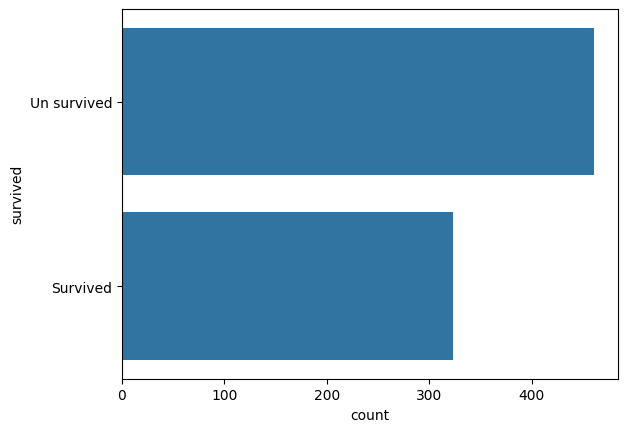

In [22]:
sns.countplot(data.survived)

### 4. Pre-processing

In [23]:
# convert class column into category and alone column into object type
fv = fv.astype(dtype = {'class':'category','alone':'object'})

In [24]:
fv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 784 entries, 0 to 890
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   sex          784 non-null    object  
 1   age          678 non-null    float64 
 2   fare         784 non-null    float64 
 3   class        784 non-null    category
 4   embark_town  782 non-null    object  
 5   alone        784 non-null    object  
dtypes: category(1), float64(2), object(3)
memory usage: 37.6+ KB


In [25]:
# here i can split my data set into x_train and y_train

In [26]:
x_train,x_test,y_train,y_test = train_test_split(fv,cv,test_size=0.2,stratify=cv,random_state=1)

In [27]:
x_train.head()

,sex,age,fare,class,embark_town,alone
155,male,51.0,61.3792,First,Cherbourg,False
768,male,NaN,24.1500,Third,Queenstown,False
345,female,24.0,13.0000,Second,Southampton,True
679,male,36.0,512.3292,First,Cherbourg,False
185,male,NaN,50.0000,First,Southampton,True


In [28]:
x_test

,sex,age,fare,class,embark_town,alone
277,male,NaN,0.0000,Second,Southampton,True
654,female,18.0,6.7500,Third,Queenstown,True
652,male,21.0,8.4333,Third,Southampton,True
252,male,62.0,26.5500,First,Southampton,True
54,male,65.0,61.9792,First,Cherbourg,False
...,...,...,...,...,...,...
168,male,NaN,25.9250,First,Southampton,True
731,male,11.0,18.7875,Third,Cherbourg,True
430,male,28.0,26.5500,First,Southampton,True
337,female,41.0,134.5000,First,Cherbourg,True


In [29]:
y_test

277    0
654    0
652    0
252    0
54     0
      ..
168    0
731    0
430    1
337    1
529    0
Name: survived, Length: 157, dtype: int64

In [30]:
x_train.columns

Index(['sex', 'age', 'fare', 'class', 'embark_town', 'alone'], dtype='object')

### 5. EDA

In [31]:
x_train.corr()

<ipython-input-31-e29555baf71d>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  x_train.corr()


,age,fare
age,1.000000,0.053703
fare,0.053703,1.000000


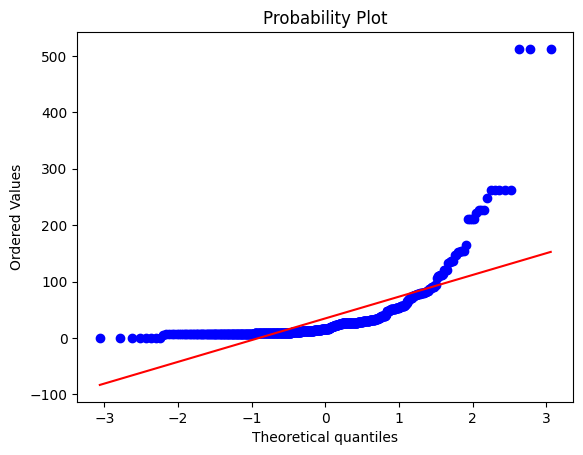

In [32]:
ss.probplot(x_train["fare"],dist = "norm",fit = True,plot = plt)   # x_train["size"] = observed data , norm = theoritical data
plt.show()

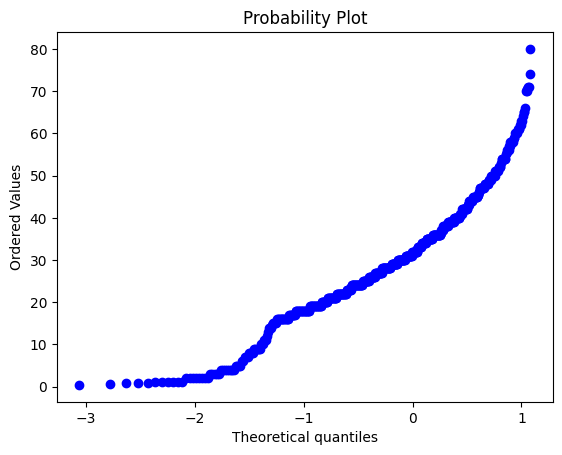

In [33]:
ss.probplot(x_train["age"],dist = "norm",fit = True,plot = plt)   # x_train["size"] = observed data , norm = theoritical data
plt.show()

In [34]:
# based on above plots, those numeric values are doesn't follows guassian distribution so I can convert this into gaussian.

### 6. Feature Engineering

In [35]:
x_train.head(3)

,sex,age,fare,class,embark_town,alone
155,male,51.0,61.3792,First,Cherbourg,False
768,male,NaN,24.1500,Third,Queenstown,False
345,female,24.0,13.0000,Second,Southampton,True


In [36]:
y_train.head(3)

155    0
768    0
345    1
Name: survived, dtype: int64

In [37]:
x_test.shape

(157, 6)

In [38]:
# split data into numerical,ordinal and nominal seperately.
numerical_data = x_train.select_dtypes(include= ['int64','float64'])
ordinal_data = x_train.select_dtypes(include= ['category'])
nominal_data = x_train.select_dtypes(include=["object"])

In [39]:
numerical_pipe = Pipeline([('imputation_1', SimpleImputer(strategy='mean')),
                           ('StandardScalar', StandardScaler()),
                           ('Power_Transform',PowerTransformer())])

In [40]:
nominal_pipe = Pipeline([('imputation_2', SimpleImputer(strategy='most_frequent')),
                         ('OH_Encoding', OneHotEncoder(sparse_output= False, drop= 'first'))])

In [41]:
ordinal_pipe = Pipeline([('Null_values_imputation_2', SimpleImputer(strategy='most_frequent')),
                         ('Ordinal_Encoding', OrdinalEncoder(categories= [['First', 'Second', 'Third']]))])

In [42]:
prepro_col_trans = ColumnTransformer(transformers= [('Ordinal_Pre-Processing', ordinal_pipe, ordinal_data.columns),
                                                    ('Nominal_Pre-Processing', nominal_pipe, nominal_data.columns),
                                                    ('numerical_Pre-Processing', numerical_pipe, numerical_data.columns)],
                                     remainder="passthrough")

In [43]:
final_pre = Pipeline([('Pre-Processing',prepro_col_trans)])

In [44]:
final_pre.fit_transform(x_train)

array([[ 0.        ,  1.        ,  0.        , ...,  0.        ,
         1.42727207,  1.36983552],
       [ 2.        ,  1.        ,  1.        , ...,  0.        ,
         0.05887141,  0.25517885],
       [ 1.        ,  0.        ,  0.        , ...,  1.        ,
        -0.40756575, -0.52953412],
       ...,
       [ 0.        ,  1.        ,  0.        , ...,  1.        ,
         0.46017518,  0.37311966],
       [ 0.        ,  1.        ,  0.        , ...,  0.        ,
        -0.18026534,  1.23554033],
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.05887141,  1.56981013]])

In [46]:
pickle.dump(final_pre,open(r"/content/drive/MyDrive/final_pre_titanic.pkl","wb"))

In [47]:
final_x_train = final_pre.fit_transform(x_train)
final_x_test = final_pre.transform(x_test)

In [48]:
final_pre.get_feature_names_out()

array(['Ordinal_Pre-Processing__class',
       'Nominal_Pre-Processing__sex_male',
       'Nominal_Pre-Processing__embark_town_Queenstown',
       'Nominal_Pre-Processing__embark_town_Southampton',
       'Nominal_Pre-Processing__alone_True',
       'numerical_Pre-Processing__age', 'numerical_Pre-Processing__fare'],
      dtype=object)

### 7. Training

In [49]:
# I take an algorithm called as MixedNB
mb = MixedNB(categorical_features= [0,1,2,3,4])
model = mb.fit(final_x_train,(y_train))

In [51]:
pickle.dump(model,open(r"/content/drive/MyDrive/titanic_model.pkl","wb"))

### 8. Model Evalution

In [52]:
print(classification_report(model.predict(final_x_test),y_test))    # my model gives 75% accuracy rate of prediction

              precision    recall  f1-score   support

           0       0.78      0.79      0.79        91
           1       0.71      0.70      0.70        66

    accuracy                           0.75       157
   macro avg       0.75      0.74      0.74       157
weighted avg       0.75      0.75      0.75       157



In [53]:
confusion_matrix(model.predict(final_x_test),y_test)

array([[72, 19],
       [20, 46]])

### 9. Testing

In [54]:
res = model.predict(final_x_test[[0]])
if res == 0:
  print("Un servived")
else:
  print("Survived")

Un servived


Finally send a querry point into the model ,then it will gives that the person is Un servived person.